<a href="https://colab.research.google.com/github/manularrea/Deep-Learning/blob/main/hungerGames_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Los Juegos del Hambre

ESTUDIANTE: `MANUELA LARREA, JERSON PEÑA`

<table><tr>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/breakfast.jpg" style="width:300px;height:300px;"></td>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/hamburger.jpg" style="width:300px;height:300px;"></td>
    <td><img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/fruits.jpg" style="width:300px;height:300px;"></td>
</tr></table>

En esta práctica vamos a enfrentarnos a un problema desafiante de clasificación de imágenes, construyendo una red neuronal profunda que sea capaz de clasificar entre diferentes tipos de comida. ¡Que comiencen los Juegos del Hambre!

## Guidelines

A lo largo del notebook encontrarás celdas que debes rellenar con tu propio código. Sigue las instrucciones del notebook y presta atención a los siguientes iconos:

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Deberás resolver el ejercicio escribiendo tu propio código o respuesta en la celda inmediatamente inferior.</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
Esto es una pista u observación de utilidad que puede ayudarte a resolver el ejercicio. Presta atención a estas pistas para comprender el ejercicio en mayor profundidad.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
Este es un ejercicio avanzado que te puede ayudar a profundizar en el tema, y a conseguir una calificación más alta. ¡Buena suerte!</font>

***

Para evitar problemas con imports o incompatibilidades se recomienda hacer uso [Google Colaboratory](https://colab.research.google.com/). Asegúrate de [conectar una GPU](https://colab.research.google.com/notebooks/gpu.ipynb), y de haber [deactivado otras sesiones que tuvieras activas](https://stackoverflow.com/a/53441194/2436578).

El siguiente código mostrará todas las gráficas en el propio notebook en lugar de generar una nueva ventana.

In [1]:
# Importaciones
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
from random import sample
from PIL import Image

from tensorflow.random import set_seed

from utils import helper # Modulo implementado
from utils import constants # Modulo implementado


np.random.seed(constants.SEED)
set_seed(constants.SEED)

## Obtención de datos

Vamos a usar un dataset de imágenes de comida disponible en [Kaggle](https://www.kaggle.com/trolukovich/food11-image-dataset).

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Usa la celda inferior para descargar el dataset de Kaggle. ¡Ojo! Cuando entregues este notebook no dejes en él tus credenciales, ya que son personales a tu usuario de Kaggle.
</font>

***

In [2]:
os.environ["KAGGLE_USERNAME"] = ""
os.environ["KAGGLE_KEY"] = ""

!kaggle datasets download trolukovich/food11-image-dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0
food11-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Revisa ahora la carpeta en la que has descargado los datos. Verás que contiene 3 subdirectorios:

* **training**, contiene las imágenes a utilizar para entrenar el modelo.
* **validation**, contiene imágenes adicionales que podrías usar como datos de entrenamiento adicionales, o para algún tipo de estrategia de validación como Early Stopping.
* **evaluation**, contiene las imágenes que debes utilizar para testear el modelo. Las imágenes de esta carpeta **solo** pueden utilizarse para medir el rendimiento del modelo tras su entrenamiento, y para nada más.

Además de esto, dentro de cada una de estas carpetas encontrarás una subcarpeta para cada una de las 11 clases de comida:

* Bread (panes)
* Dairy product (lácteos)
* Dessert (postres)
* Egg (huevos)
* Fried food (fritos)
* Meat (carnes)
* Noodles-Pasta (pasta)
* Rice (arroz)
* Seafood (pescado y marisco)
* Soup (sopas)
* Vegetable-Fruit (vegetales y frutas)

Para facilitar los pasos de procesamiento que vendrán a continuación, vamos a definir algunas variables que nos indiquen dónde están almacenados los diferentes conjuntos de datos.

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Crea variables <b>TRAINDIR</b>, <b>VALDIR</b> y <b>TESTDIR</b>, cada una conteniendo una cadena de texto con la ruta al directorio donde están los datos de entrenamiento, validación y evaluación, respectivamente.
</font>

***

In [3]:
TRAINDIR, VALDIR, TESTDIR = 'training','validation', 'evaluation'

### Reducción de clases

Con el fin de hacer este problema más accesible de cara a la práctica, vamos a centrarnos solo en seis de las clases de comida disponibles: `Bread`, `Dairy product`, `Dessert`, `Egg`, `Fried food` y `Meat`. Para ello, se provee el código siguiente, que elimina de los datos descargados las carpetas correspondientes a imágenes de las otras clases.

In [4]:
# Adecuo la función para ejecutar el proyecto en windows local. 

valid_classes = {"Bread", "Dairy product", "Dessert", "Egg", "Fried food", "Meat"}
datasets = {TRAINDIR, VALDIR, TESTDIR}

for dataset in datasets:
    for classdir in pathlib.Path(dataset).glob("*"):  # Find subfolders with classes
        class_name = classdir.name
        if class_name not in valid_classes:  # Ignore those in valid_classes
            print(f"Deleting {classdir}...")
            for fname in classdir.glob("*.jpg"):  # Remove each image file
                fname.unlink()
            classdir.rmdir()  # Remove folder

### Carga de datos

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Utiliza la función <i>image_dataset_from_directory</i> para crear tres objetos de tipo Dataset, uno para cada una de las particiones de datos (training, validation, evaluation)
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
¿Cuál es el tamaño ideal al que cargar las imágenes en memoria?
Esto es algo con lo que tendrás que experimentar a lo largo del notebook, por lo que probablemente tendrás que volver más de una vez a esta celda y probar cambiando ese tamaño.
</font>

***

Observemos como son las imagenes y sus tamaños

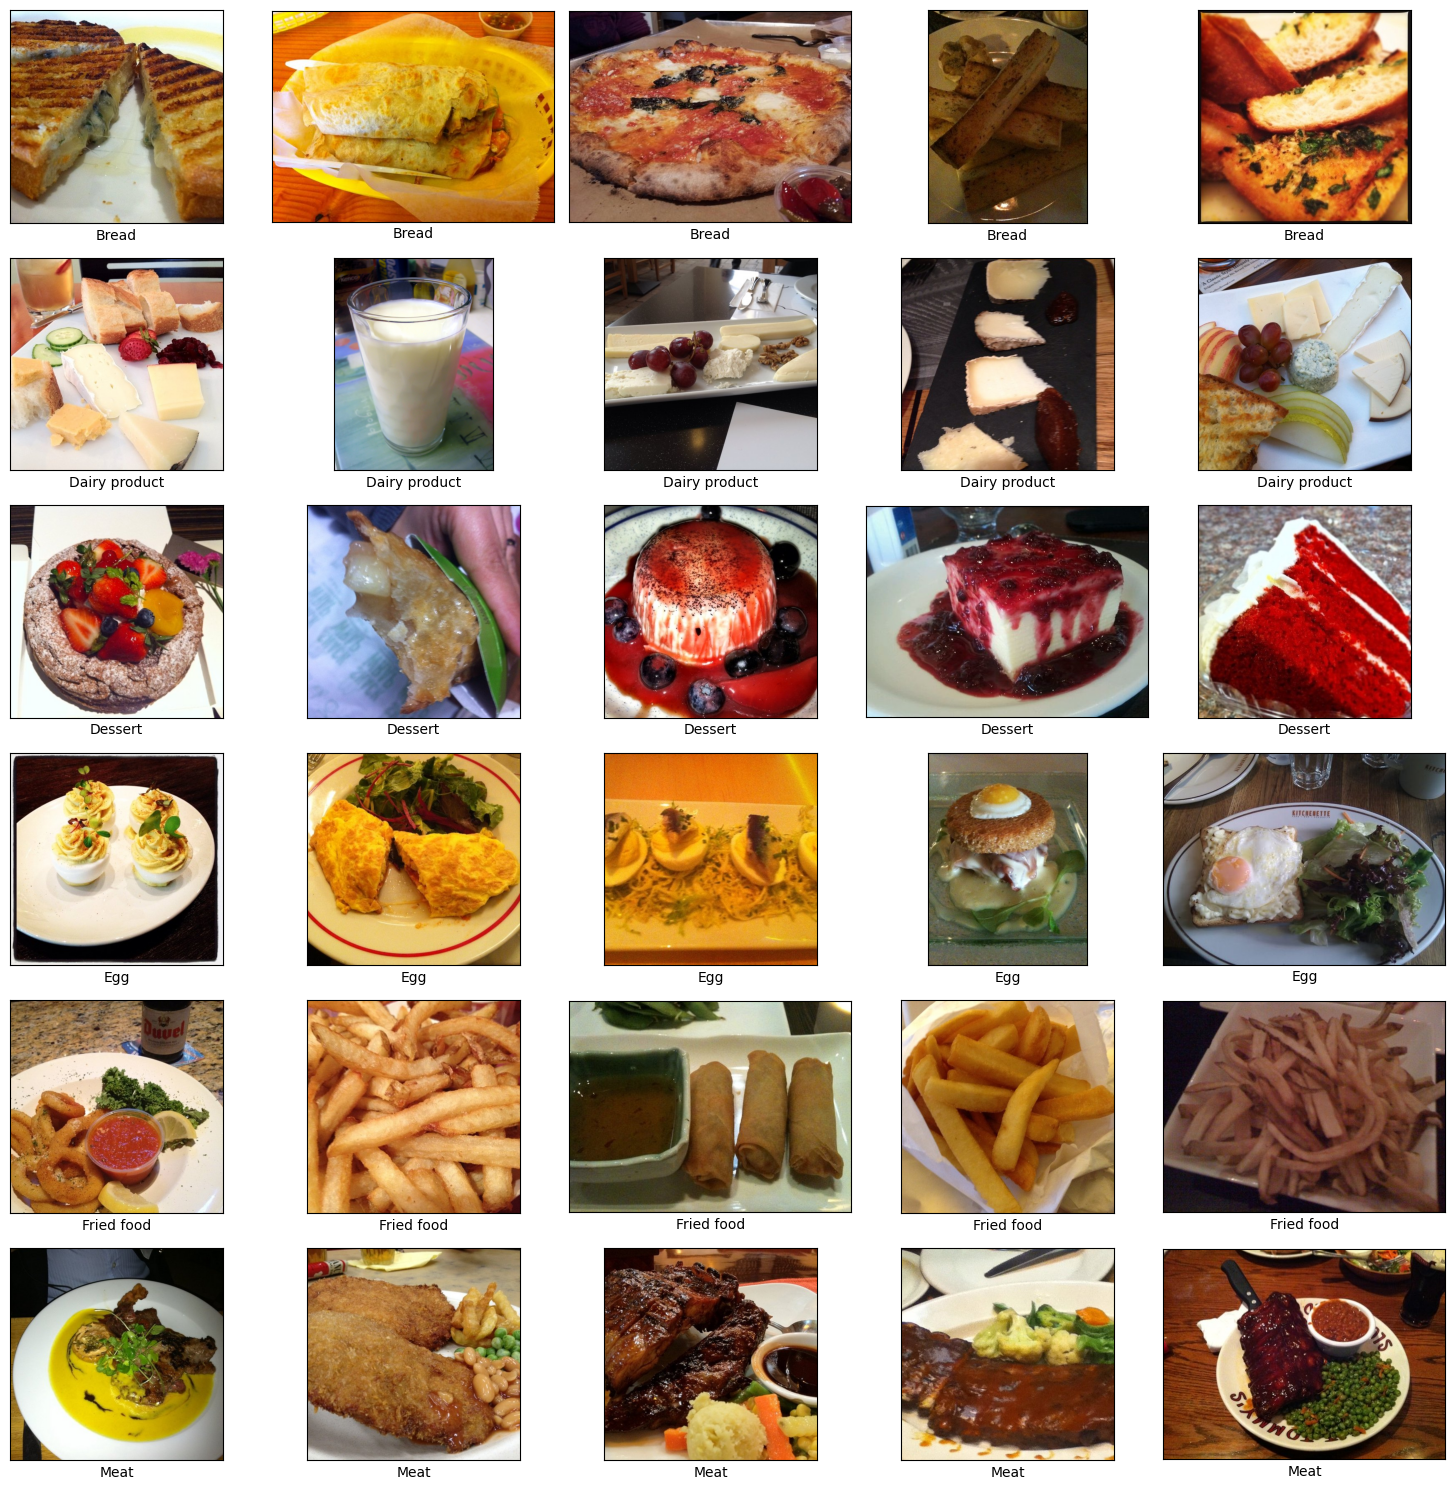

In [5]:
train = {}

for i in os.listdir(TRAINDIR):
  train[i] = os.listdir(os.path.join(TRAINDIR, i))

fig,axs = plt.subplots(len(train.keys()), 5, figsize=(15,15))

for i, item in enumerate(os.listdir(TRAINDIR)):
  images = sample(train[item], 5)

  for j, image in enumerate(images):
    img = Image.open(os.path.join(TRAINDIR, item, image))
    axs[i,j].imshow(img)
    axs[i,j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

## Preprocesamiento

Lo más flexible aquí es tener una función lo suficientemente modular para poder experimentar con el tamaño de las imagenes (image_size) y el tamaño del lote (batch_size).

Iniciamos con un experimento que toma tamaños de imagen de 32x32 y un lote de 64. Estos tamaños son los suficientemente pequeños para tener un procesamiento "respetable", y lo suficientemente grandes como para poder capturar características importantes de las imágenes.

In [6]:
train_dataset = helper.create_dataset(TRAINDIR)

Found 6082 files belonging to 6 classes.


Exploremos las características del dataset.

In [7]:
helper.get_batch_info(train_dataset)

Tamaño del batch de entrada: (32, 32, 32, 3)
Tamaño del batch de salida: (32, 6)
Batch de entrada:
[[[[127.28906  122.28906  118.78906 ]
   [133.92969  131.42969  129.92969 ]
   [139.92969  134.92969  131.42969 ]
   ...
   [102.92969   70.07031   51.      ]
   [120.71094   92.71094   78.71094 ]
   [142.35938  119.359375 105.359375]]

  [[133.13281  129.13281  126.13281 ]
   [138.28906  133.78906  130.78906 ]
   [142.78906  137.78906  134.78906 ]
   ...
   [106.39844   71.        50.132812]
   [ 91.36719   60.476562  44.390625]
   [122.86719   99.13281   87.265625]]

  [[137.64844  132.64844  129.64844 ]
   [141.64844  137.14844  134.14844 ]
   [145.70312  137.70312  134.70312 ]
   ...
   [ 88.55469   64.5       47.445312]
   [ 48.90625   31.203125  21.5     ]
   [ 85.890625  61.351562  48.203125]]

  ...

  [[126.35156  112.35156  112.35156 ]
   [189.05469  210.64844  245.35156 ]
   [171.64844  196.64844  226.64844 ]
   ...
   [164.85156  165.70312  171.14844 ]
   [161.5      162.5    

La salida es clara:


*   Las imagenes quedaron correctamente re-escaladas a un tamaño de 32X32px.
*   El tamaño del lote es 64
*   Las salidas quedaron codificadas de forma binaria (One-Hot)
*   El número de canales es 3 (RGB). Esto significa que cada píxel se encuentra en el rango [0,255], por la formula: ${2}^8-1$. Esto puede generar problemas a la hora del entrenamiento. No obstante, resolveremos esto más adelante.



Podemos proseguir, entonces, creando el resto de datasets.

In [8]:
val_dataset = helper.create_dataset(VALDIR)
test_dataset = helper.create_dataset(TESTDIR)

Found 2108 files belonging to 6 classes.
Found 2070 files belonging to 6 classes.


In [9]:
helper.get_batch_info(val_dataset, full_view = False)

Tamaño del batch de entrada: (32, 32, 32, 3)
Tamaño del batch de salida: (32, 6)


In [10]:
helper.get_batch_info(test_dataset, full_view = False)

Tamaño del batch de entrada: (32, 32, 32, 3)
Tamaño del batch de salida: (32, 6)


Se conservan las características del dataset de train

## Construyendo tu propia red

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Diseña una red neuronal profunda que obtenga el mejor acierto posible sobre los datos de test. Puedes usar los datos de entrenamiento y validación como te parezca mejor, pero <b>sólo</b> puedes usar los datos de test para evaluar el acierto de tu modelo. Debes obtener una red capaz de alcanzar al menos un 45% de acierto sobre los datos de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
Algunas recomendaciones y estrategias que pueden ayudar a mejorar tu diseño de red:
    
- <b>Arquitectura</b>: usa todos los trucos que has aprendido en los ejercicios anteriores: capas convolucionales + pooling, activaciones ReLU, dropout... asegúrate también de utilizar un buen optimizador, con una función de error (loss) adecuada, así como una función de activación en la capa de salida que sea adecuada para esta clase de problema (clasificación multiclase).
- <b>Desarrollo incremental</b>: empieza por redes pequeñas, con un número pequeño de parámetros, de forma que puedas comprobar rápidamente qué tal funcionan. Después, puedes hacer tu red más grande en tres direcciones: mayor tamaño de imágenes de entrada, más capas, y más kernels por capa convolucional o unidades por capa densa. Si aumentas el tamaño de las imágenes de entrada, asegúrate de añadir también más capas Convolution+Pooling, para que así a la capa Flatten solo lleguen imágenes muy pequeñas (10x10 píxeles o menos).
- <b>Tamaño de imágenes</b>: configurar los `Dataset` para que carguen imágenes de mayor tamaño puede mejorar significativamente el rendimiento de tu red. Pero ten cuidado, ¡también puedes encontrarte errores de falta de memoria (CUDA memory error) si cargas imágenes a un tamaño demasiado grande! Para esta práctica, un tamaño mayor a 256 puede ser demasiado grande...
- <b>Controlar el número de épocas</b>: Usa una <a href="https://keras.io/api/callbacks/early_stopping/">**estrategia de EarlyStopping**</a> para monitorizar el loss de los datos de validación, y así detener el entrenamiento cuando tras un número de épocas esa loss no haya decrecido. Configurar la EarlyStopping para restaurar los mejores parámetros encontrados durante la optimización también puede resultarte útil.
- <b>Sobreajuste</b>: si tu red obtiene un accuracy casi perfecto en entrenamiento, puede que estés sufriendo sobreajuste (aunque puede que no...). Prueba a incrementar el nivel de Dropout en las capas Dense para comprobar si así obtienes mejoras en el test.
- <b>Demasiado bueno para ser verdad</b>: si tu red obtiene resultados muy buenos, del orden del 90% o más de acierto en test... sospecha. Es posible que estés mezclando los datos de entrenamiento y test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
    
Como ejercicio avanzado, añade las siguiente estrategias a tu red:

- Usa **técnicas de "image augmentation"** para aumentar artificialmente tu dataset de entrenamiento. Para ello, explora las <a href="https://keras.io/api/layers/preprocessing_layers/image_augmentation/">capas de augmentation disponibles en Keras</a>.
- Usa capas de <a href="https://keras.io/api/layers/normalization_layers/batch_normalization/">BatchNormalization</a> para facilitar el entrenamiento de la red. Revisa en las diapositivas de clase cuál es la forma adecuada de colocarlas en la red.
    
Usando estos trucos y los mencionados en el punto anterior, es posible obtener más de un 60% de acierto en el conjunto de test.

</font>

***

In [11]:
loss_list = []
accuracy_list = []

### **Modelo 1** 

Iniciamos con un modelo muy básico. El optimizador utilizado es 'sgd', que es un optimizador de gradiente estocástico simple.

El modelo consta de las siguientes capas:

1. Capa de escalado (Rescaling)

2. Capa de convolución (Conv2D)

3. Capa de aplanamiento (Flatten)

4. Capa completamente conectada (Dense)

La función de pérdida utilizada es 'categorical_crossentropy', que es adecuada para problemas de clasificación multiclase. 

In [12]:
modelo_1 = helper.create_model()

c:\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
modelo_1.fit(train_dataset, epochs=1)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2577 - loss: 1.7346


In [14]:
loss_1, acc_1 = modelo_1.evaluate(test_dataset)
print(f"Loss {loss_1:.3}, accuracy {acc_1:.1%}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2756 - loss: 1.6844
Loss 1.68, accuracy 28.5%


In [15]:
loss_list.append(loss_1)
accuracy_list.append(acc_1)

### **Modelo 2**

Probamos con el optimizador 'adam', que es un optimizador de gradiente estocástico adaptativo.


In [16]:
modelo_2 = helper.create_model(optimizer = 'adam')

In [17]:
modelo_2.fit(train_dataset, epochs=1, validation_data=val_dataset)

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2715 - loss: 1.7503 - val_accuracy: 0.3563 - val_loss: 1.5630


In [18]:
loss_2, acc_2 = modelo_2.evaluate(test_dataset)
print(f"Loss {loss_2:.3}, accuracy {acc_2:.1%}")
loss_list.append(loss_2)
accuracy_list.append(acc_2)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3399 - loss: 1.6075
Loss 1.59, accuracy 34.0%


### **Modelo 3**

Para hacer el modelo más robusto, agregamos una capa de Pooling después de la capa de convolución para reducir la dimensionalidad de las características extraídas

Respecto al modelo anterior, se le incrementa:

1. Capa de escalado (Rescaling)
2. Capa de convolución (Conv2D)
3. Capa de pooling
4. Capa de aplanamiento
5. Capa completamente conectada



In [19]:
modelo_3 = helper.create_model_3()

In [20]:
modelo_3.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2374 - loss: 1.7452 - val_accuracy: 0.3368 - val_loss: 1.5825
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3484 - loss: 1.5541 - val_accuracy: 0.3838 - val_loss: 1.5007
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4025 - loss: 1.4722 - val_accuracy: 0.3890 - val_loss: 1.4705
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4194 - loss: 1.4285 - val_accuracy: 0.3971 - val_loss: 1.4515
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4274 - loss: 1.4058 - val_accuracy: 0.3961 - val_loss: 1.4452
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4399 - loss: 1.3838 - val_accuracy: 0.4094 - val_loss: 1.4439
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4516 - loss: 1.3629 - val_accuracy: 0.3999 - val_loss: 1.4481
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4578 - loss: 1.3533 - val_accuracy: 0.

In [21]:
loss_3, acc_3 = modelo_3.evaluate(test_dataset)
print(f"Loss {loss_3:.3}, accuracy {acc_3:.1%}")
loss_list.append(loss_3)
accuracy_list.append(acc_3)

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3918 - loss: 1.4805
Loss 1.46, accuracy 39.9%


### **Modelo 4**

Para hacer el modelo aún más robusto, podemos aumentar el número de capas convolucionales y densas, lo que permite aprender características más complejas de las imágenes.

Respecto al modelo anterior, se le incrementa:

1. Capa de escalado

2. Capa de convolución

3. Capa de pooling: reduce la dimensionalidad de la salida de la capa de convolución para reducir la cantidad de parámetros.

4. Capa de convolucióng: aplica otro filtro de convolución a la imagen de entrada para extraer características más complejas.

5. Capa de pooling: reduce la dimensionalidad de la salida de la capa de convolución para reducir la cantidad de parámetros.

6. Capa de aplanamiento: aplana la salida de la capa de pooling para prepararla para la capa densa.

7. Capa completamente conectada: clasifica las características aplanadas en una de las clases posibles.

8. Capa de dropout: aplica regularización para evitar sobreajuste.


In [22]:
modelo_4 = helper.create_model_4()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
modelo_4.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2191 - loss: 5.8620 - val_accuracy: 0.3046 - val_loss: 1.6634
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2640 - loss: 1.7208 - val_accuracy: 0.3202 - val_loss: 1.6362
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2897 - loss: 1.6505 - val_accuracy: 0.3425 - val_loss: 1.5581
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3164 - loss: 1.6024 - val_accuracy: 0.4065 - val_loss: 1.5291
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3385 - loss: 1.5695 - val_accuracy: 0.4089 - val_loss: 1.4871
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3623 - loss: 1.5278 - val_accuracy: 0.4179 - val_loss: 1.4443
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3864 - loss: 1.4857 - val_accuracy: 0.4042 - val_loss: 1.4434
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3872 - loss: 1.4990 - val_accu

In [24]:
loss_4, acc_4 = modelo_4.evaluate(test_dataset)
print(f"Loss {loss_4:.3}, accuracy {acc_4:.1%}")
loss_list.append(loss_4)
accuracy_list.append(acc_4)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4240 - loss: 1.4435
Loss 1.42, accuracy 43.7%


### **Modelo 5**

En este modelo implemento los mismos parámetros de entrada del modelo 4, pero se le incrementa:
1. Aumentación de datos con ImageDataGenerator, con variaciones en: rotation, shift, shear, zoom, and flip.
2. Parada de entrenamiento con EarlyStopping para la métrica de accuracy 

In [25]:
datagen = helper.create_image_augmentor()

In [26]:
early_stopping = helper.create_early_stopping()

In [27]:
modelo_5 = helper.create_model_4()

In [28]:
train_images, train_labels = helper.extract_numpy_matrices(train_dataset)

In [29]:
history=modelo_5.fit(
    datagen.flow(train_images, train_labels),
    epochs = 50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/50
  7/191 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1449 - loss: 39.7625

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2016 - loss: 7.0015 - val_accuracy: 0.2576 - val_loss: 1.6895
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.2639 - loss: 1.7169 - val_accuracy: 0.3477 - val_loss: 1.5816
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2753 - loss: 1.6712 - val_accuracy: 0.3567 - val_loss: 1.5588
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2996 - loss: 1.6349 - val_accuracy: 0.3771 - val_loss: 1.5121
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3254 - loss: 1.6033 - val_accuracy: 0.3544 - val_loss: 1.5274
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3456 - loss: 1.5768 - val_accuracy: 0.3843 - val_loss: 1.4977
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3377 - loss: 1.5864 - val_accuracy: 0.3828 - val_loss: 1.5189
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3519 - loss: 1.5340 - val_accuracy: 0.376

In [30]:
loss_5, acc_5 = modelo_5.evaluate(test_dataset)
print(f"Loss {loss_5:.3}, accuracy {acc_5:.1%}")
loss_list.append(loss_5)
accuracy_list.append(acc_5)

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5185 - loss: 1.2874
Loss 1.29, accuracy 50.8%


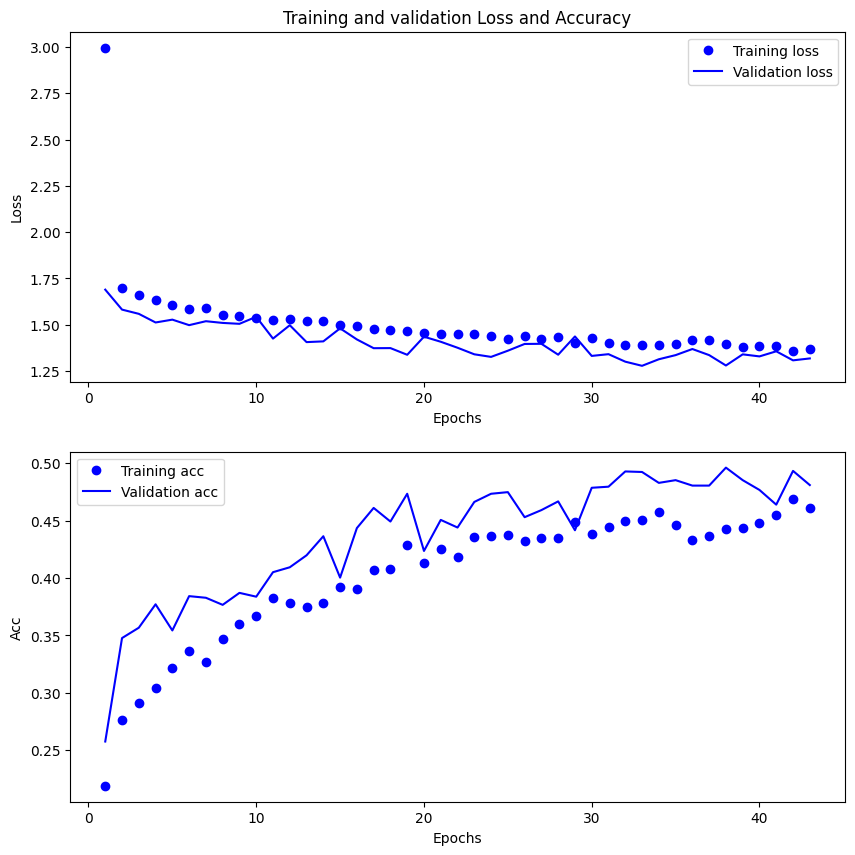

In [31]:
history_dict = history.history
helper.plot_loss_and_accuracy(history_dict['loss'], history_dict['val_loss'], history_dict['accuracy'], history_dict['val_accuracy'])

## Red con transferencia del aprendizaje

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    Usando la estrategia "bottleneck" implementa una red que haga transferencia del aprendizaje desde la red VGG16. Si lo haces correctamente, esta red debe obtener mejores resultados que la red que diseñaste en el apartado anterior, con al menos un 80% de acierto sobre el conjunto de test.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
Algunos consejos para mejorar tu diseño de red:
    
- Incluye una o más capas Dense, con sus funciones de activación apropiadas, antes de la capa de salida.
- Intenta usar una capa de tipo [GlobalAveragePooling](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/) en lugar de la capa Flatten. Esta capa calcula una media de todos los valores de píxeles para cada canal, y en algunas ocasiones produce mejores resultados que la capa Flatten.
- ¡Y no olvides todos los consejos del apartado anterior! También aplican aquí.
</font>

***

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>

Para mejorar aún más los resultados de tu red, utiliza las siguientes ideas:

- Usa las estrategias PRO del ejercicio anterior.
- Prueba otras redes pre-entrenadas de <a href="https://keras.io/api/applications/">Keras Applications</a>, como Xception o MobileNetV2, o alguna red de las familias EfficientNetV2 o ConvNeXt.
- Usa una estrategia de transfer learning más avanzada, como fine-tuning o una combinación de bottleneck features y fine-tuning. Revisa las diapositivas de clase para saber cómo.
   
Si empleas todos estos trucos, es posible alcanzar más de un 90% de acierto en el conjunto de test.

</font>

***

### **Modelo 6: Red con transferencia del aprendizaje**

En este modelo se está utilizando la red VGG16 pre-entrenada. Al probar el modelo sobre el dataset de 32x32 no se reflejaron mejoras, por lo tanto se decide empezar a variar los argumentos de resolución de las imágenes. 

Este modelo tiene:

1. Capa de Entrada (Lambda)

2. Capas de Aumento de Datos (RandomFlip, RandomTranslation) para reducir el sobreajuste

3. Capa VGG16 Base: en este modelo uso la red VGG16 pre-entrenada como base para la extracción de características.

4. Capa de Pooling Global (GlobalAveragePooling2D)

5. Capas Densas Superiores: añadidas encima de la capa de pooling global para realizar la clasificación de las características extraídas por la red VGG16. 

6. Capa de Salida (Dense)

Además tiene parada de entrenamiento con EarlyStopping para la métrica de accuracy 

Para este modelo se usa una resolucion de 128x128

In [32]:
train_dataset_128 = helper.create_dataset(TRAINDIR, (128,128))
val_dataset_128 = helper.create_dataset(VALDIR, (128,128))
test_dataset_128 = helper.create_dataset(TESTDIR, (128,128))

Found 6082 files belonging to 6 classes.
Found 2108 files belonging to 6 classes.
Found 2070 files belonging to 6 classes.


In [33]:
train_dataset_256 = helper.create_dataset(TRAINDIR, (256,256))
val_dataset_256 = helper.create_dataset(VALDIR, (256,256))
test_dataset_256 = helper.create_dataset(TESTDIR, (256,256))

Found 6082 files belonging to 6 classes.
Found 2108 files belonging to 6 classes.
Found 2070 files belonging to 6 classes.


In [34]:
modelo_6 = helper.create_vgg16_transfer_learning_model(input_shape=(128,128, constants.IMAGE_CHANNELS))

c:\Python312\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
history_6 = modelo_6.fit(train_dataset_128, epochs=5, validation_data=val_dataset_128,
                         callbacks=[early_stopping])

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 103s 531ms/step - accuracy: 0.2516 - loss: 1.7847 - val_accuracy: 0.4682 - val_loss: 1.3899
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 567ms/step - accuracy: 0.4098 - loss: 1.4659 - val_accuracy: 0.5474 - val_loss: 1.1935
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 564ms/step - accuracy: 0.4736 - loss: 1.3542 - val_accuracy: 0.5731 - val_loss: 1.1468
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 564ms/step - accuracy: 0.5005 - loss: 1.2954 - val_accuracy: 0.5920 - val_loss: 1.1053
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 108s 565ms/step - accuracy: 0.5236 - loss: 1.2302 - val_accuracy: 0.6072 - val_loss: 1.0606


In [36]:
loss_6, acc_6 = modelo_6.evaluate(test_dataset_128)
print(f"Loss {loss_6:.3}, accuracy {acc_6:.1%}")
loss_list.append(loss_6)
accuracy_list.append(acc_6)

65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.6158 - loss: 1.0152
Loss 1.04, accuracy 60.8%


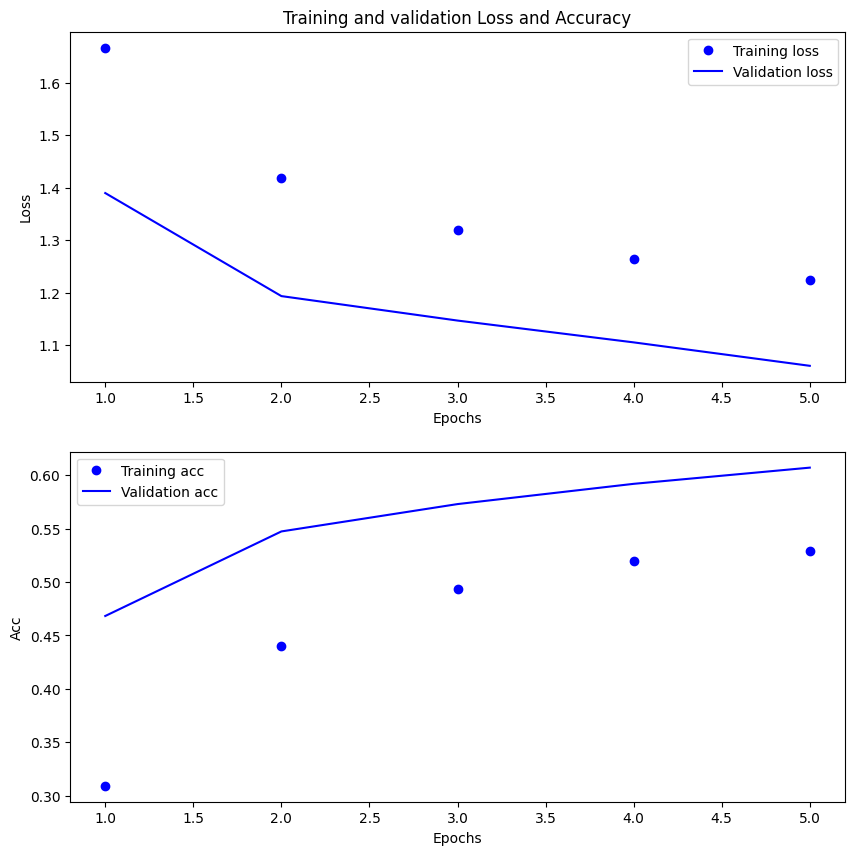

In [37]:
history_dict_6 = history_6.history
helper.plot_loss_and_accuracy(history_dict_6['loss'], history_dict_6['val_loss'], history_dict_6['accuracy'], history_dict_6['val_accuracy'])

Hay una clara mejora en el accuracy del modelo aumentando la resolución. Con todo fijo, es posible llegar a un accuracy sobre test de al menos 80% aumentando solamente la resolucion? Veamoslo...

### **Modelo 7: VGG16 con más resolución** 
Es momento de aumentar (aun más) la resolución de las imágenes. Es el mismo modelo anterior pero se le incrementa la resolución.

In [38]:
modelo_7 = helper.create_vgg16_transfer_learning_model(input_shape=(256,256, constants.IMAGE_CHANNELS))

In [39]:
history_7 = modelo_7.fit(train_dataset_256, epochs=5, validation_data=val_dataset_256,
                         callbacks=[early_stopping])

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.2578 - loss: 1.7465 - val_accuracy: 0.5142 - val_loss: 1.3316
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.4333 - loss: 1.4357 - val_accuracy: 0.6029 - val_loss: 1.1109
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.5145 - loss: 1.2564 - val_accuracy: 0.6428 - val_loss: 0.9895
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.5394 - loss: 1.2011 - val_accuracy: 0.6584 - val_loss: 0.9484
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5846 - loss: 1.1386 - val_accuracy: 0.6637 - val_loss: 0.9296


In [40]:
loss_7, acc_7 = modelo_7.evaluate(test_dataset_256)
print(f"Loss {loss_7:.3}, accuracy {acc_7:.1%}")
loss_list.append(loss_7)
accuracy_list.append(acc_7)

65/65 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6740 - loss: 0.8825
Loss 0.881, accuracy 66.9%


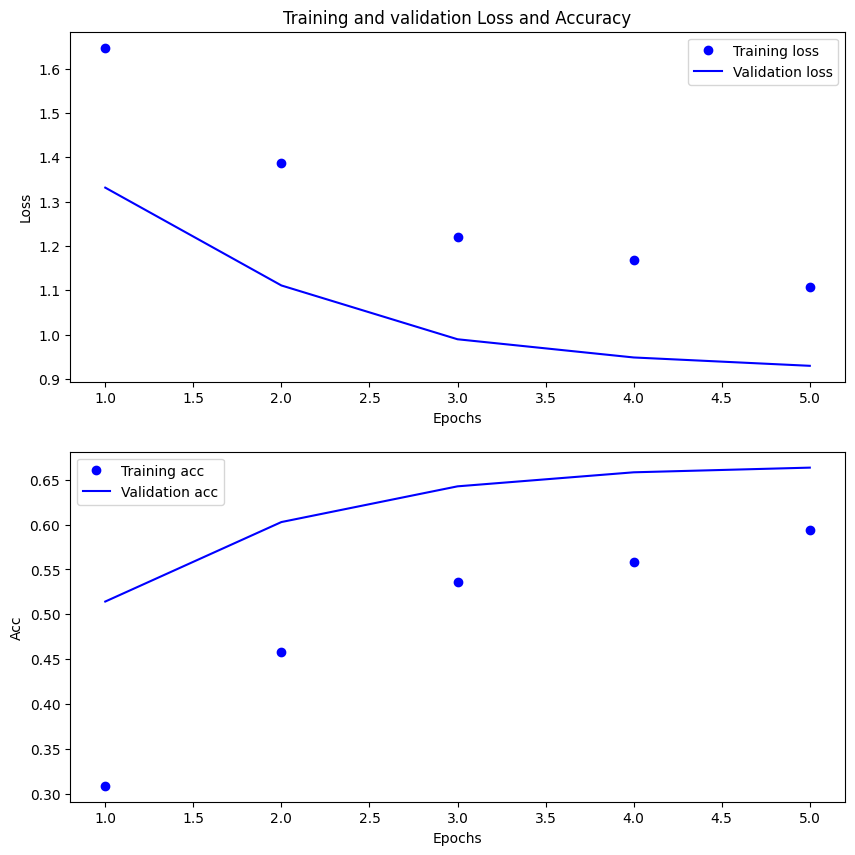

In [41]:
history_dict_7 = history_7.history
helper.plot_loss_and_accuracy(history_dict_7['loss'], history_dict_7['val_loss'], history_dict_7['accuracy'], history_dict_7['val_accuracy'])

### **Modelo 8: VGG16 con más epochs** 
Por poco se llega al 80% de accuracy, así que aumentamos el numero de epocas.

In [42]:
modelo_8 = helper.create_vgg16_transfer_learning_model(input_shape=(256,256, constants.IMAGE_CHANNELS))

In [43]:
history_8 = modelo_8.fit(train_dataset_256, epochs=20, validation_data=val_dataset_256,
                         callbacks=[early_stopping])

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.2677 - loss: 1.7528 - val_accuracy: 0.4962 - val_loss: 1.3575
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.4433 - loss: 1.4240 - val_accuracy: 0.6015 - val_loss: 1.1169
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.5141 - loss: 1.2898 - val_accuracy: 0.6414 - val_loss: 1.0228
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.5682 - loss: 1.1636 - val_accuracy: 0.6656 - val_loss: 0.9392
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.5760 - loss: 1.1427 - val_accuracy: 0.6679 - val_loss: 0.9202
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.6088 - loss: 1.0642 - val_accuracy: 0.6741 - val_loss: 0.9097
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.6017 - loss: 1.0671 - val_accuracy: 0.6969 - val_loss: 0.8649
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.6306 - loss: 1.0116 - val_accu

In [44]:
loss_8, acc_8 = modelo_8.evaluate(test_dataset_256)
print(f"Loss {loss_8:.3}, accuracy {acc_8:.1%}")
loss_list.append(loss_8)
accuracy_list.append(acc_8)

65/65 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7412 - loss: 0.7072
Loss 0.711, accuracy 73.4%


In [45]:
history_dict_8 = history_8.history
helper.plot_loss_and_accuracy(history_dict_8['loss'], history_dict_8['val_loss'], history_dict_8['accuracy'], history_dict_8['val_accuracy'])

Mejoras evidentes. Ahora probemos algo más avanzado...

### **Modelo 9:** InceptionResNetV2
Este modelo tiene:

1. Capa de Entrada (Lambda)
Preprocesamiento de las imágenes de entrada para adaptarlas al formato esperado por la red InceptionResNetV2.
2. Capas de Aumento de Datos (RandomFlip, RandomTranslation)

3. Capa InceptionResNetV2 Base: red InceptionResNetV2 pre-entrenada.

4. Capa de Pooling Global (GlobalAveragePooling2D):
Reduce la dimensionalidad de las características extrayendo características globales de las imágenes.

5. Capas Densas Superiores:con activación ReLU y regularización Dropout para evitar el sobreajuste.

6. Capa de Salida (Dense)

Además se aumentan las exigencias: mayior numero de epochs y el dataset mas pesado para la memoria 256x256

In [46]:
modelo_9 = helper.create_inceptionresnetv2_transfer_learning_model()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [47]:
history_9 = modelo_9.fit(train_dataset_256, epochs=20, validation_data=val_dataset_256,
                         callbacks=[early_stopping])

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.4122 - loss: 1.6547 - val_accuracy: 0.7315 - val_loss: 0.8460
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6209 - loss: 1.0428 - val_accuracy: 0.7661 - val_loss: 0.6995
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6678 - loss: 0.9569 - val_accuracy: 0.8126 - val_loss: 0.6065
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6823 - loss: 0.9145 - val_accuracy: 0.7922 - val_loss: 0.6133
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.7115 - loss: 0.8439 - val_accuracy: 0.8131 - val_loss: 0.5788
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.7241 - loss: 0.8185 - val_accuracy: 0.8178 - val_loss: 0.5444
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7264 - loss: 0.8063 - val_accuracy: 0.8340 - val_loss: 0.5379
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7348 - loss: 0.7725 - val_accu

In [48]:
loss_9, acc_9 = modelo_9.evaluate(test_dataset_256)
print(f"Loss {loss_9:.3}, accuracy {acc_9:.1%}")
loss_list.append(loss_9)
accuracy_list.append(acc_9)

65/65 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8455 - loss: 0.4780
Loss 0.465, accuracy 85.1%


In [49]:
history_dict_9 = history_9.history
helper.plot_loss_and_accuracy(history_dict_9['loss'], history_dict_9['val_loss'], history_dict_9['accuracy'], history_dict_9['val_accuracy'])

## Informe final y resumen de resultados

<img src="https://albarji-labs-materials.s3-eu-west-1.amazonaws.com/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Escribe en la siguiente celda un pequeño informe con:
    <ul>
        <li>Una tabla de resultados, indicando qué diseños de red has probado y qué resultados en test has obtenido. Puede usar un estilo de tabla como el que se muestra abajo.</li>
        <li>De las estrategias y diseños que has ido probando, ¿qué ha funcionado y qué no?</li>
    </ul>
</font>

***

In [79]:
acc_model= {'Modelo {}'.format(i): locals()['acc_{}'.format(i)] for i in range(1, 10)}

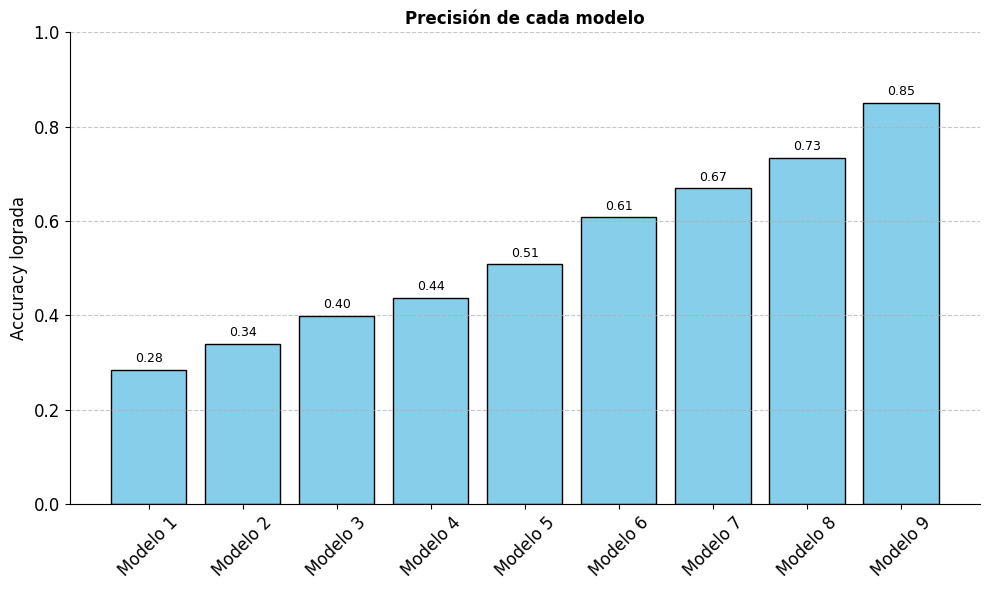

In [78]:
helper.plot_accuracy(acc_model)

### **Tabla de resumen**


| Modelo | Procesamiento de imagen | Red Neuronal | Estrategia de Entrenamiento | Datos de Validación | Epochs | Accuracy en Prueba |
|--------|--------------------------|--------------|-----------------------------|---------------------|--------|--------------------|
| 1      | Tamaño 32x32, batch size 32 | Conv(4, relu) + Flatten + Dense(6, softmax) | Train from scratch | No | 1 | 28% |
| 2      | Tamaño 32x32, batch size 32 | Conv(4, linear) + Flatten + Dense(6, sigmoid) | Adam optimizer | Sí | 1 | 34% |
| 3      | Tamaño 32x32, batch size 32 | Conv(4, linear) + MaxPooling2D + Flatten + Dense(6, sigmoid) | Adam optimizer | Sí | 10 | 40% |
| 4      | Tamaño 32x32, batch size 32 | Conv(32, relu) + MaxPooling2D + Conv(64, relu) + MaxPooling2D + Conv(128, relu) + MaxPooling2D + Flatten + Dense(256, relu) + Dropout(0.5) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer | Sí | 10 | 44% |
| 5      | Tamaño 32x32, batch size 32 | Conv(32, relu) + MaxPooling2D + Conv(64, relu) + MaxPooling2D + Conv(128, relu) + MaxPooling2D + Flatten + Dense(256, relu) + Dropout(0.5) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer + Data Augmentation + Early Stopping | Sí | 50 | 51% |
| 6      | Tamaño 128x128, batch size 32 |VGG16 + Global Average Pooling + Dense(512, relu) + Dropout(0.6) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer + Early Stopping + Bottleneck | Sí | 5 | 61% |
| 7      | Tamaño 256x256, batch size 32 |VGG16 + Global Average Pooling + Dense(512, relu) + Dropout(0.6) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer + Early Stopping + Bottleneck | Sí | 5 | 67% |
| 8      | Tamaño 256x256, batch size 32 | VGG16 + Global Average Pooling + Dense(512, relu) + Dropout(0.6) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer + Early Stopping + Bottleneck | Sí | 20 | 73% |
| 9      | Tamaño 256x256, batch size 32 |InceptionResNetV2 + Global Average Pooling + Dense(512, relu) + Dropout(0.6) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adama optimizer + Early Stopping + Bottleneck | Sí | 20 | 85% |


1. **Entrenamiento desde cero vs. Transferencia de aprendizaje**: Se observó que el uso de transferencia de aprendizaje, especialmente con redes pre-entrenadas como VGG16 y InceptionResNetV2, produjo un rendimiento superior en comparación con el entrenamiento desde cero. Esto se evidencia en los modelos 6, 7, 8 y 9, que alcanzaron una precisión de prueba más alta que los modelos entrenados desde cero.

2. **Estrategias de regularización**: Se implementaron estrategias de regularización, como Dropout, en los modelos 6, 7, 8 y 9 para mitigar el sobreajuste. Estas estrategias ayudaron a mejorar la capacidad de generalización de los modelos y evitar el sobreajuste en los conjuntos de datos de entrenamiento.

3. **Data Augmentation**: Se introdujo la técnica de Data Augmentation en el modelo 5 para aumentar la diversidad del conjunto de datos de entrenamiento. Esta técnica resultó en una mejora significativa en la precisión de prueba, lo que demuestra su eficacia para mejorar el rendimiento del modelo en datos no vistos. 

4. **Early Stopping**: La implementación de Early Stopping en los modelos 5, 6, 7, 8 y 9 contribuyó a evitar el sobreajuste al detener el entrenamiento cuando la pérdida en el conjunto de validación dejó de disminuir. Esto ayudó a mejorar la capacidad de generalización de los modelos y a evitar el sobreajuste. De hecho, cuando se corrio una version del modelo 5 sin introducir Data Augmentation la curva de validation accuracy estaba muuuy por debajo de accuracy training.

Por temas de rendimiento no se aumentaron más el número de epochs ni se jugó mas con el batch_size y el image_size. Sin embargo, el desarrollo incremental demosotró que aumentar el numero de epochs y el tamaño del dataset de entrada puede generar mejoras significativas en el accuracy.

Ahora, basandome en las lecciones aprendidas, hare una afirmacion osada que sería interesante probar dejando el computador procesando todo un finde:

Es posible que ese accurazy sobrepase el 85% facilmente con esta receta:

| Modelo | Procesamiento de imagen | Red Neuronal | Estrategia de Entrenamiento | Datos de Validación | Epochs | Accuracy en Prueba |
|--------|--------------------------|--------------|-----------------------------|---------------------|--------|--------------------|
| Hipotetico 10     | Tamaño 256x256, batch size 32 | InceptionResNetV2 + Global Average Pooling + Dense(512, relu) + Dropout(0.6) + Dense(128, relu) + Dropout(0.5) + Dense(6, softmax) | Adam optimizer + Early Stopping + Data Augmentation | Sí | 100 | Más de 85% |


Pero bueno, será un experimento que solo podremos hacer después de sustentar el TFM porque seguro se quedaría la computadora ocupada por 2 días 

<div style="text-align:center;">
    <img src="https://i.pinimg.com/564x/ef/72/23/ef7223e065e9eb593053ec264be3db9a.jpg" style="width:200px;height:150px;">
</div>


